In [17]:
import optuna
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import umap
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('../input/tsta_a_1791676_sm7407.csv')
data

,ID,X,n,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),2% proof stress (Mpa),Tensile strength (Mpa),Elongation (%)
0,A 5005 P,1,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,95,125,2
1,A 5005 P,1,4,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,120,145,2
2,A 5005 P,1,6,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,145,165,2
3,A 5005 P,1,8,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,165,185,2
4,A 5005 P,2,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,85,120,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,A 5N01 P,1,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,115,125,3
111,A 5N01 P,1,6,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,135,145,2
112,A 5N01 P,3,2,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,85,120,4
113,A 5N01 P,3,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,105,140,3


In [10]:
correlation = data[["2% proof stress (Mpa)", "Tensile strength (Mpa)", "Elongation (%)"]].corr()
correlation

,2% proof stress (Mpa),Tensile strength (Mpa),Elongation (%)
2% proof stress (Mpa),1.000000,0.906414,-0.390692
Tensile strength (Mpa),0.906414,1.000000,-0.081633
Elongation (%),-0.390692,-0.081633,1.000000


In [4]:
params = {
    "learning_rate": 0.01,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state":42,
    "max_depth": 5,
    "n_estimators": 1000, 
    "colsample_bytree": 0.7,
    "min_data_in_leaf": 2 #モデリングのために調整
}

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


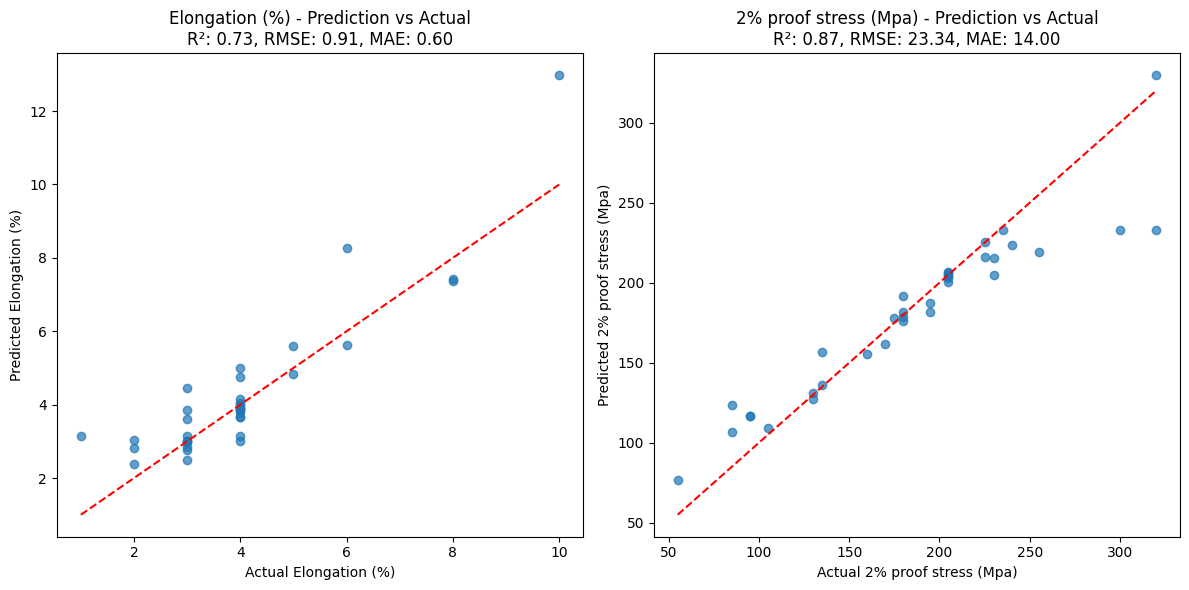

In [5]:
# 説明変数と目的変数
wt_columns = [col for col in data.columns if '(wt%)' in col]
additional_features = ['X', 'n']
all_features = wt_columns + additional_features
X = data[all_features]
y_elongation = data["Elongation (%)"]
y_proof_stress = data["2% proof stress (Mpa)"]

# トレーニングとテストデータに分割
X_train, X_test, y_train_elongation, y_test_elongation = train_test_split(
    X, y_elongation, test_size=0.3, random_state=42
)
_, _, y_train_proof_stress, y_test_proof_stress = train_test_split(
    X, y_proof_stress, test_size=0.3, random_state=42
)

# 学習データ用LightGBMモデルのトレーニング
model_elongation = lgb.LGBMRegressor(**params)
model_proof_stress = lgb.LGBMRegressor(**params)

model_elongation.fit(X_train, y_train_elongation)
model_proof_stress.fit(X_train, y_train_proof_stress)

# テストデータでの予測値
y_pred_elongation = model_elongation.predict(X_test)
y_pred_proof_stress = model_proof_stress.predict(X_test)

# 指標計算関数
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

# Elongation (%) の評価指標
r2_elongation, rmse_elongation, mae_elongation = calculate_metrics(y_test_elongation, y_pred_elongation)

# 2% proof stress (Mpa) の評価指標
r2_proof_stress, rmse_proof_stress, mae_proof_stress = calculate_metrics(y_test_proof_stress, y_pred_proof_stress)

# テストデータでの予測値と実測値のプロット
plt.figure(figsize=(12, 6))

# Elongation (%) のプロット
plt.subplot(1, 2, 1)
plt.scatter(y_test_elongation, y_pred_elongation, alpha=0.7)
plt.plot(
    [y_test_elongation.min(), y_test_elongation.max()],
    [y_test_elongation.min(), y_test_elongation.max()],
    'r--'
)
plt.xlabel('Actual Elongation (%)')
plt.ylabel('Predicted Elongation (%)')
plt.title(f'Elongation (%) - Prediction vs Actual\n'
          f'R²: {r2_elongation:.2f}, RMSE: {rmse_elongation:.2f}, MAE: {mae_elongation:.2f}')

# 2% proof stress (Mpa) のプロット
plt.subplot(1, 2, 2)
plt.scatter(y_test_proof_stress, y_pred_proof_stress, alpha=0.7)
plt.plot(
    [y_test_proof_stress.min(), y_test_proof_stress.max()],
    [y_test_proof_stress.min(), y_test_proof_stress.max()],
    'r--'
)
plt.xlabel('Actual 2% proof stress (Mpa)')
plt.ylabel('Predicted 2% proof stress (Mpa)')
plt.title(f'2% proof stress (Mpa) - Prediction vs Actual\n'
          f'R²: {r2_proof_stress:.2f}, RMSE: {rmse_proof_stress:.2f}, MAE: {mae_proof_stress:.2f}')

plt.tight_layout()
plt.show()

In [6]:
# Optuna内で使用する全データ学習モデル
model_full_elongation = lgb.LGBMRegressor(**params)
model_full_proof_stress = lgb.LGBMRegressor(**params)

model_full_elongation.fit(X, y_elongation)
model_full_proof_stress.fit(X, y_proof_stress)

# データ全体での目的変数の範囲を取得
elongation_min, elongation_max = y_elongation.min(), y_elongation.max()
proof_stress_min, proof_stress_max = y_proof_stress.min(), y_proof_stress.max()

# 試行結果を記録するためのリスト
trial_results = []

def objective(trial):
    # wt%列の試行値をサンプリング
    proportions = {
        col: trial.suggest_float(col, X[col].min(), X[col].max())
        for col in wt_columns
    }
    # 合計が100になるよう正規化
    total = sum(proportions.values())
    normalized_proportions = {col: (value / total) * 100 for col, value in proportions.items()}
    
    # normalized_proportionsを小数点2桁に
    normalized_proportions = {col: round(value, 2) for col, value in normalized_proportions.items()}

    # Xとnの試行値を整数型でサンプリング
    additional_values = {
        'X': trial.suggest_int('X', int(X['X'].min()), int(X['X'].max())),
        'n': trial.suggest_int('n', int(X['n'].min()), int(X['n'].max()))
    }
    
    # サンプルデータ作成
    input_data = pd.DataFrame([{**normalized_proportions, **additional_values}])

    # 予測値の計算（全データ学習モデルを使用）
    pred_elongation = model_full_elongation.predict(input_data)[0]
    pred_proof_stress = model_full_proof_stress.predict(input_data)[0]

    # 制約条件をチェック
    if pred_elongation < 15 or pred_proof_stress < 130:
        return -1e6  # 制約を満たさない場合、非常に低いスコアを返す

    # 正規化（0～1）
    norm_elongation = (pred_elongation - elongation_min) / (elongation_max - elongation_min)
    norm_proof_stress = (pred_proof_stress - proof_stress_min) / (proof_stress_max - proof_stress_min)
    
    # スコアの計算（正規化後の加重和）
    score = 0.5 * norm_elongation + 0.5 * norm_proof_stress

    # 試行結果を記録
    trial_results.append({
        **normalized_proportions,
        **additional_values,
        "Predicted Elongation (%)": pred_elongation,
        "Predicted 2% proof stress (Mpa)": pred_proof_stress,
        "Score": score
    })

    return score


# Optunaで最適化
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=1000)


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2024-12-04 20:22:12,781] A new study created in memory with name: no-name-4fee0e6f-8871-4f44-bbe7-689a4621e905
[I 2024-12-04 20:22:12,814] Trial 0 finished with value: -1000000.0 and parameters: {'Fe (wt%)': 0.21239882614641975, 'Mn (wt%)': 0.713528586743338, 'Si (wt%)': 0.1897990912717108, 'Al (wt%)': 97.20737291193336, 'Mg (wt%)': 1.1254866780573298, 'Ti (wt%)': 0.015599452033620266, 'Cu (wt%)': 0.024646688973455958, 'Cr (wt%)': 0.2165440364437338, 'Zn (wt%)': 0.08112265129175297, 'X': 3, 'n': 1}. Best is trial 0 with value: -1000000.0.
[I 2024-12-04 20:22:12,841] Trial 1 finished with value: -1000000.0 and parameters: {'Fe (wt%)': 0.3433801674756387, 'Mn (wt%)': 0.6260075541923121, 'Si (wt%)': 0.11185086660174143, 'Al (wt%)': 95.14821533800307, 'Mg (wt%)': 1.2528309708184673, 'Ti (wt%)': 0.030424224295953775, 'Cu (wt%)': 0.061980514530579026, 'Cr (wt%)': 0.10798625466052894, 'Zn (wt%)': 0.04703520542178461, 'X': 3, 'n': 2}. Best is trial 0 with value: -1000000.0.
[I 2024-12-04 20

In [7]:
results_df = pd.DataFrame(trial_results)
results_df

,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),X,n,Predicted Elongation (%),Predicted 2% proof stress (Mpa),Score
0,0.15,0.39,0.11,94.86,4.35,0.00,0.04,0.08,0.03,1,1,16.935403,131.439251,0.593999
1,0.15,0.39,0.10,94.84,4.37,0.00,0.04,0.08,0.03,1,1,16.935403,131.439251,0.593999
2,0.15,0.39,0.10,94.53,4.68,0.01,0.04,0.08,0.03,1,1,16.173572,133.216453,0.574505
3,0.15,0.37,0.11,94.66,4.57,0.01,0.04,0.08,0.03,1,1,16.173572,133.216453,0.574505
4,0.15,0.39,0.10,94.56,4.64,0.00,0.04,0.08,0.03,1,1,16.173572,133.925474,0.575668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,0.13,0.33,0.10,94.90,4.40,0.00,0.05,0.06,0.02,1,1,16.936300,130.991244,0.593291
307,0.15,0.36,0.12,94.70,4.53,0.01,0.04,0.08,0.02,1,1,16.173572,133.010991,0.574168
308,0.14,0.34,0.11,94.81,4.42,0.01,0.05,0.09,0.02,1,1,16.936300,130.730231,0.592863
309,0.15,0.33,0.11,95.01,4.26,0.00,0.05,0.08,0.02,1,1,16.936300,131.439251,0.594025


In [8]:
# 重複を削除
results_df = results_df.drop_duplicates()
results_df

,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),X,n,Predicted Elongation (%),Predicted 2% proof stress (Mpa),Score
0,0.15,0.39,0.11,94.86,4.35,0.00,0.04,0.08,0.03,1,1,16.935403,131.439251,0.593999
1,0.15,0.39,0.10,94.84,4.37,0.00,0.04,0.08,0.03,1,1,16.935403,131.439251,0.593999
2,0.15,0.39,0.10,94.53,4.68,0.01,0.04,0.08,0.03,1,1,16.173572,133.216453,0.574505
3,0.15,0.37,0.11,94.66,4.57,0.01,0.04,0.08,0.03,1,1,16.173572,133.216453,0.574505
4,0.15,0.39,0.10,94.56,4.64,0.00,0.04,0.08,0.03,1,1,16.173572,133.925474,0.575668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,0.13,0.33,0.10,94.90,4.40,0.00,0.05,0.06,0.02,1,1,16.936300,130.991244,0.593291
307,0.15,0.36,0.12,94.70,4.53,0.01,0.04,0.08,0.02,1,1,16.173572,133.010991,0.574168
308,0.14,0.34,0.11,94.81,4.42,0.01,0.05,0.09,0.02,1,1,16.936300,130.730231,0.592863
309,0.15,0.33,0.11,95.01,4.26,0.00,0.05,0.08,0.02,1,1,16.936300,131.439251,0.594025


In [9]:
# Scoreの高い順にソート
results_df.sort_values("Score", ascending=False, inplace=True)
results_df


/var/folders/3q/gwgy4r2561v6xx__yjlk15b80000gn/T/ipykernel_29723/836108709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df.sort_values("Score", ascending=False, inplace=True)


,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),X,n,Predicted Elongation (%),Predicted 2% proof stress (Mpa),Score
78,0.14,0.36,0.09,94.79,4.48,0.00,0.05,0.07,0.02,1,1,16.936300,131.451913,0.594046
159,0.15,0.34,0.11,94.93,4.30,0.00,0.05,0.09,0.02,1,1,16.936300,131.439251,0.594025
176,0.14,0.33,0.11,94.87,4.39,0.00,0.05,0.09,0.02,1,1,16.936300,131.439251,0.594025
153,0.14,0.36,0.11,94.95,4.29,0.00,0.05,0.08,0.02,1,1,16.936300,131.439251,0.594025
156,0.15,0.35,0.11,94.93,4.30,0.00,0.05,0.09,0.02,1,1,16.936300,131.439251,0.594025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0.15,0.35,0.12,94.70,4.53,0.01,0.05,0.08,0.02,1,1,16.174468,133.010991,0.574195
307,0.15,0.36,0.12,94.70,4.53,0.01,0.04,0.08,0.02,1,1,16.173572,133.010991,0.574168
144,0.16,0.33,0.12,94.75,4.49,0.01,0.05,0.09,0.02,1,1,16.174468,132.909270,0.574028
299,0.13,0.36,0.11,94.64,4.63,0.01,0.05,0.06,0.02,1,1,16.174468,132.768446,0.573797


In [15]:
results_df[:10]

,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),X,n,Predicted Elongation (%),Predicted 2% proof stress (Mpa),Score
78,0.14,0.36,0.09,94.79,4.48,0.0,0.05,0.07,0.02,1,1,16.9363,131.451913,0.594046
159,0.15,0.34,0.11,94.93,4.30,0.0,0.05,0.09,0.02,1,1,16.9363,131.439251,0.594025
176,0.14,0.33,0.11,94.87,4.39,0.0,0.05,0.09,0.02,1,1,16.9363,131.439251,0.594025
153,0.14,0.36,0.11,94.95,4.29,0.0,0.05,0.08,0.02,1,1,16.9363,131.439251,0.594025
156,0.15,0.35,0.11,94.93,4.30,0.0,0.05,0.09,0.02,1,1,16.9363,131.439251,0.594025
160,0.14,0.34,0.11,94.99,4.26,0.0,0.05,0.09,0.02,1,1,16.9363,131.439251,0.594025
164,0.14,0.34,0.11,94.98,4.27,0.0,0.05,0.10,0.02,1,1,16.9363,131.439251,0.594025
168,0.15,0.33,0.11,94.99,4.26,0.0,0.05,0.09,0.02,1,1,16.9363,131.439251,0.594025
174,0.14,0.36,0.11,94.85,4.37,0.0,0.05,0.10,0.02,1,1,16.9363,131.439251,0.594025
178,0.15,0.36,0.11,94.82,4.39,0.0,0.05,0.09,0.02,1,1,16.9363,131.439251,0.594025


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


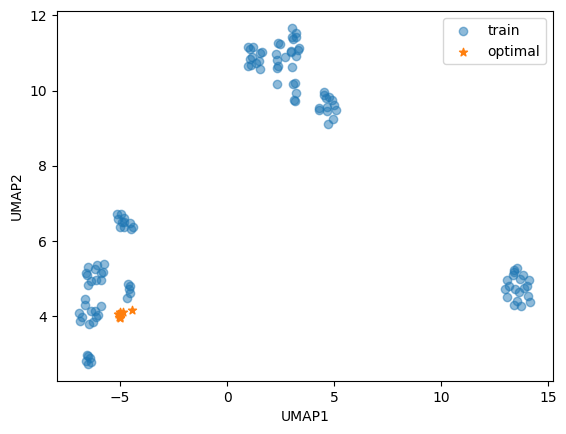

In [19]:
scaler_x = StandardScaler()
scaler_x.fit(X)

X_train = scaler_x.transform(X)
X_test = scaler_x.transform(results_df[all_features][:10])

umap_ = umap.UMAP(
    n_components=2, random_state=42, n_neighbors=15
)  # n_neighborsのデフォルト値は15

result_umap = umap_.fit(X_train)
X_train_umap = result_umap.transform(X_train)
X_test_umap = result_umap.transform(X_test)

train_umap_df = pd.DataFrame(X_train_umap, columns=["UMAP1", "UMAP2"])
test_umap_df = pd.DataFrame(X_test_umap, columns=["UMAP1", "UMAP2"])

plt.scatter(train_umap_df["UMAP1"], train_umap_df["UMAP2"], alpha=0.5)
plt.scatter(test_umap_df["UMAP1"], test_umap_df["UMAP2"], marker="*")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(["train", "optimal"])
plt.show()